In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [ ]:
# Base directory where you extracted the Kaggle dataset
DATA_DIR = Path("mallorn-astronomical-classification-challenge")

In [ ]:
# Setting filter colours for plotting
filter_colours = {
    'u': '#6A5ACD',
    'g': '#2ca02c',
    'r': '#d62728',
    'i': '#ff7f0e',
    'z': '#8c564b',
    'y': '#1b1b1b'
}

In [ ]:
# Load metadata
train_log = pd.read_csv(DATA_DIR / "train_log.csv")
test_log = pd.read_csv(DATA_DIR / "test_log.csv")

# Quick look
print(train_log.head())
print(test_log.head())

In [ ]:
split_name = "split_01"

lc_path = DATA_DIR / split_name / "train_full_lightcurves.csv"
train_lc = pd.read_csv(lc_path)

print(train_lc.shape)
train_lc.head()

In [ ]:
# Filter log to objects in this split
split_log = train_log[train_log['split'] == split_name]

# Keep only relevant lightcurves
split_lc = train_lc[train_lc['object_id'].isin(split_log['object_id'])]

# Merge if needed
data = split_lc.merge(
    split_log[['object_id', 'target', 'SpecType', 'Z', 'EBV']],
    on='object_id',
    how='left'
)

In [ ]:
# Define the name of the chosen object
object_ID = 'amon_imloth_luin'  # update to the actual object ID in your Mallorn data

# Define filters
filters = ['u', 'g', 'r', 'i', 'z', 'y']

# Create dictionaries to store flux, time, and error for each filter
fluxes, times, errors = {}, {}, {}

for f in filters:
    mask = (data['Filter'] == f) & (data['object_id'] == object_ID)
    fluxes[f] = np.array(data.loc[mask, 'Flux'])
    times[f] = np.array(data.loc[mask, 'Time (MJD)'])
    errors[f] = np.array(data.loc[mask, 'Flux_err'])

# Quick check
for f in filters:
    print(f"{f}-band: {len(fluxes[f])} points")

In [ ]:
# Filter the merged data for this object
object_data = data.loc[data['object_id'] == object_ID]

# Extract redshift, EBV, and spectral type directly from the merged DataFrame
redshift = object_data['Z'].values[0]
ebv = object_data['EBV'].values[0]
SpecType = object_data['SpecType'].values[0] if 'SpecType' in object_data.columns else None

print(f"Redshift: {redshift}, EBV: {ebv}, Spectral Type: {SpecType}")

In [ ]:
#Importing necessary package
from extinction import fitzpatrick99

#Defining function to de-extinct a set of flux values
def jurassic_park (flux, eff_wl):
    A_lambda = fitzpatrick99(eff_wl, ebv * 3.1) #3.1 = Standard Milky Way value
    flux_ext = flux * 10**((A_lambda)/2.5)
    return flux_ext, A_lambda

In [ ]:
# Effective wavelength for each band (Ångströms) - SVO Filter Profile Service
eff_wavelengths = {
    'u': 3641,
    'g': 4704,
    'r': 6155,
    'i': 7504,
    'z': 8695,
    'y': 10056
}

# De-extincting lightcurves and storing results in dictionaries
fluxes_ext, A_lambdas = {}, {}

for band in eff_wavelengths:
    fluxes_ext[band], A_lambdas[band] = jurassic_park(fluxes[band], np.array([eff_wavelengths[band]]))

# Optional: overwrite original flux arrays if desired
u_flux, g_flux, r_flux = fluxes_ext['u'], fluxes_ext['g'], fluxes_ext['r']
i_flux, z_flux, y_flux = fluxes_ext['i'], fluxes_ext['z'], fluxes_ext['y']

# Print extinction values
for band in eff_wavelengths:
    print(f"{band}-band extinction = {A_lambdas[band]}")

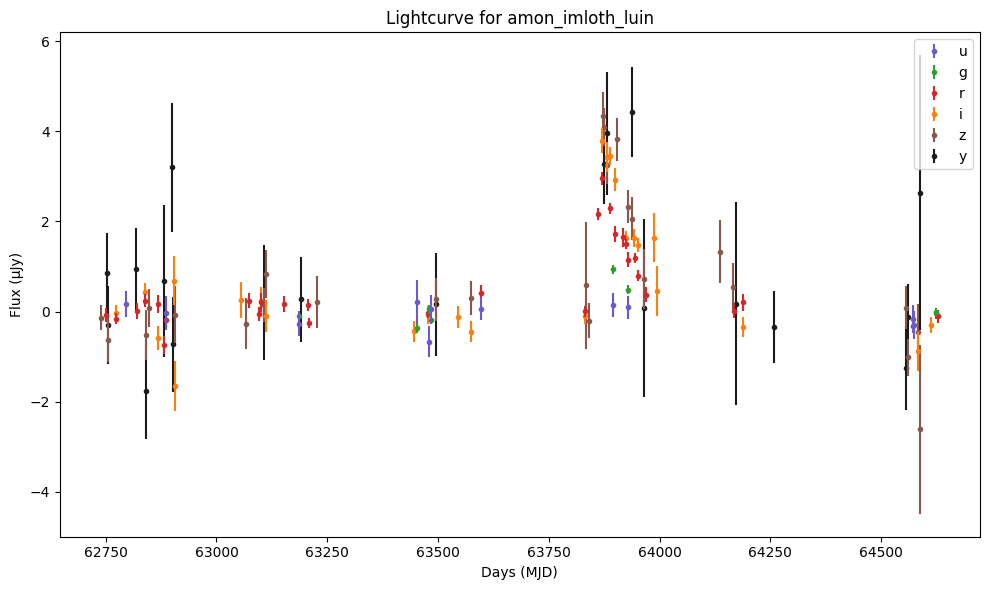

In [15]:
plt.figure(figsize=[10,6])

# Plot each filter
for i, band in enumerate(['u','g','r','i','z','y']):
    plt.errorbar(
        times[band], 
        fluxes_ext[band], 
        yerr=errors[band], 
        label=band, 
        fmt='.', 
        color=filter_colours[band], 
        zorder=6-i  # higher zorder for top layers
    )

plt.xlabel('Days (MJD)')
plt.ylabel('Flux (μJy)')
plt.title(f'Lightcurve for {object_ID}')
plt.legend()
plt.tight_layout()
plt.show()